# Pilot Study  
  
In order to evaluate the effect of global clinical trial pathway (GCT) on the post-market safety events (PMSE), this pilot study uses propensity score matching (PSM) and cox proportional hazard model (Cox). PSM classifies GCT/others with covatiates (i.e. Lag, JStudysize, Orphan, Biologic, ATC and Followup). Cox shows the association with GCT and PMSE.  


## Preprocessing
  

In [170]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set_palette('pastel')

In [171]:
# import dataset
pilot = pd.read_csv('./pilot_study.csv',
                    encoding='cp932',
                    parse_dates = [1])

pilot.head(5)

,Ingredient,Approval_date,Days_for_approval,GCT,Lag,Studysize,JStudysize,Biologic,FIC,ATC,Event,TimetoEvent
0,コラゲナーゼ（クロストリジウム ヒストリチクム）,2015-07-03,337,0,1977.0,1184,102,0,1,M,0,1621
1,スクロオキシ水酸化鉄,2015-09-28,313,0,670.0,494,494,0,0,V,0,1534
2,ルストロンボパグ,2015-09-28,285,0,NaN,220,220,0,1,B,0,1534
3,イロプロスト,2015-09-28,277,0,4395.0,406,49,0,1,B,0,1534
4,エボロクマブ（遺伝子組み換え）,2016-01-22,308,1,189.0,5115,579,1,1,C,0,1418


In [172]:
# check missing values
pilot.isnull().sum()

Ingredient            0
Approval_date         0
Days_for_approval     0
GCT                   0
Lag                  37
Studysize             0
JStudysize            0
Biologic              0
FIC                   0
ATC                   0
Event                 0
TimetoEvent           0
dtype: int64

In [173]:
# set index
pilot.set_index(['Ingredient'], inplace = True)

In [174]:
# convery days into years
pilot.Lag = pilot.Lag / 365
pilot.TimetoEvent = pilot.TimetoEvent / 365

In [175]:
# fill missing values
pilot['Lag'].fillna(1, inplace = True)
pilot['Lag'].isnull().sum()

0

In [176]:
# create a new column, which stands for proportion of JStudysize
pilot['Pr_JStudysize'] = pilot.JStudysize / pilot.Studysize

In [177]:
# create a new column, which extracts the year in each Ingredient's Approval_date
import datetime
pilot['Approval_year'] = pilot.Approval_date.dt.year
pilot['Approval_year'] = pilot.Approval_year.astype('category')

pilot.Approval_year.dtype

CategoricalDtype(categories=[2011, 2012, 2013, 2014, 2015, 2016], ordered=False)

In [178]:
# drop Approval_date column
pilot.drop('Approval_date',
           axis = 1,
           inplace = True)

In [179]:
# create a new column, which categorizes ATC
def atc_cate(x) :
    if x == 'J' :
        return 'J'
    elif x == 'L' :
        return 'L'
    else :
        return 'others'

pilot['ATC'] = pilot.ATC.apply(atc_cate)
pilot.ATC.value_counts()

others    115
L          54
J          16
Name: ATC, dtype: int64

## Expolatory Data Analysis (EDA)

### Lag

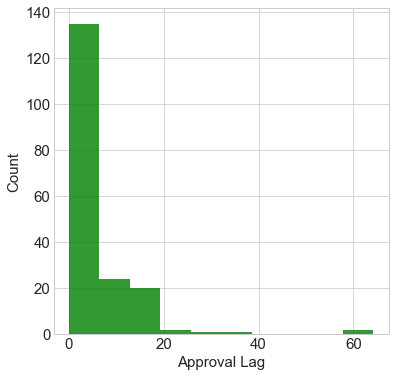

In [180]:
# check the distribution of Lag
plt.figure(figsize = (6, 6))
plt.rcParams["font.size"] = 15

_ = plt.hist(pilot.Lag,
             bins = 10,
             alpha = 0.8,
             color = 'green')
_ = plt.xlabel('Approval Lag')
_ = plt.ylabel('Count')

plt.show()

In [181]:
# convert Lag into log-scale Lag
pilot['Lag_log'] = pilot.Lag.apply(np.log10)

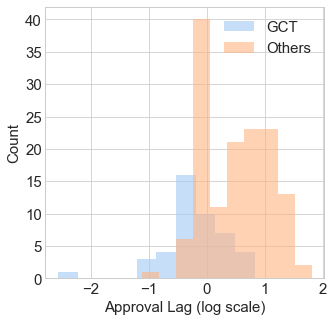

In [182]:
# check the distributions of Lag_log
plt.figure(figsize = (5, 5))
plt.rcParams["font.size"] = 15

_ = plt.hist(pilot.query('GCT == 1').Lag_log,
             bins = 10,
             alpha = 0.6)
_ = plt.hist(pilot.query('GCT == 0').Lag_log,
             bins = 10,
             alpha = 0.6)
_ = plt.xlabel('Approval Lag (log scale)')
_ = plt.ylabel('Count')
_ = plt.legend(['GCT', 'Others'])

plt.show()

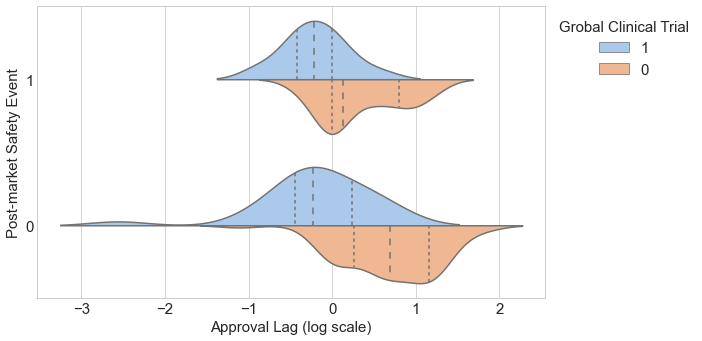

In [183]:
# plot the relationship between Lag_log and PMSE
plt.figure(figsize = (10, 5))

_ = sns.violinplot(x='Lag_log',
                   y='Event',
                   data = pilot,
                   orient = 'horizontal',
                   order = [1, 0],
                   hue = 'GCT',
                   hue_order = [1, 0],
                   split = True,
                   inner = 'quartile',
                   legend = False)
_ = plt.xlabel('Approval Lag (log scale)')
_ = plt.ylabel('Post-market Safety Event')
_ = plt.legend(title = 'Grobal Clinical Trial',
               loc='upper left',
               bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

### JStudysize

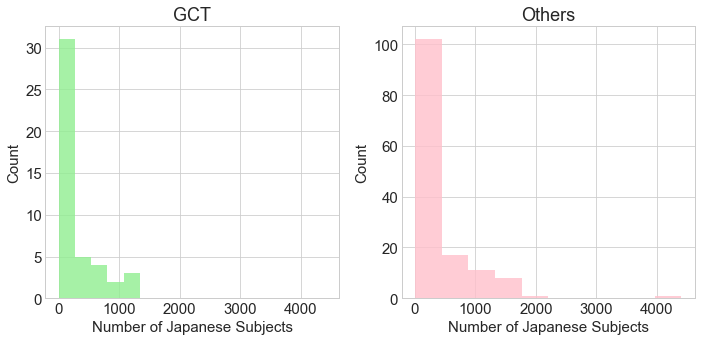

In [184]:
# check the distributions of JStudysize
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(1, 2,
                       sharex = True,
                       figsize = (10, 5))

ax[0].hist(pilot.query('GCT == 1').JStudysize,
           bins = 5,
           alpha = 0.8,
           color = 'lightgreen')
ax[1].hist(pilot.query('GCT == 0').JStudysize,
           bins = 10,
           alpha = 0.8,
           color = 'pink')

titles = ['GCT', 'Others']
for i in range(2) :
    ax[i].set_xlabel('Number of Japanese Subjects')
    ax[i].set_ylabel('Count')
    ax[i].set_title(titles[i])
plt.tight_layout()

plt.show()

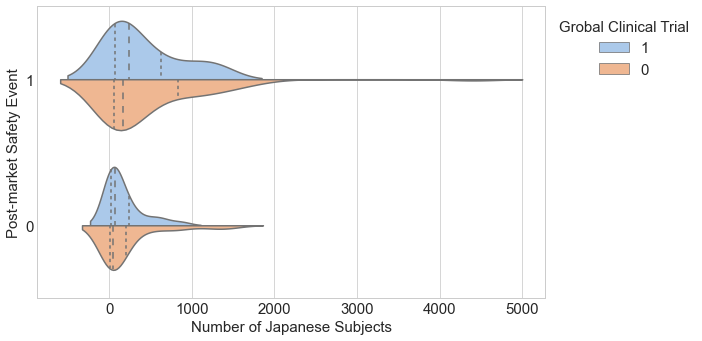

In [185]:
# plot the relationship between JStudysize and PMSE
plt.figure(figsize = (10, 5))

_ = sns.violinplot(x='JStudysize',
                   y='Event',
                   data = pilot,
                   orient = 'horizontal',
                   order = [1, 0],
                   hue = 'GCT',
                   hue_order = [1, 0],
                   split = True,
                   inner = 'quartile',
                   legend = False)
_ = plt.xlabel('Number of Japanese Subjects')
_ = plt.ylabel('Post-market Safety Event')
_ = plt.legend(title = 'Grobal Clinical Trial',
               loc='upper left',
               bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

### Pr_JStudysize

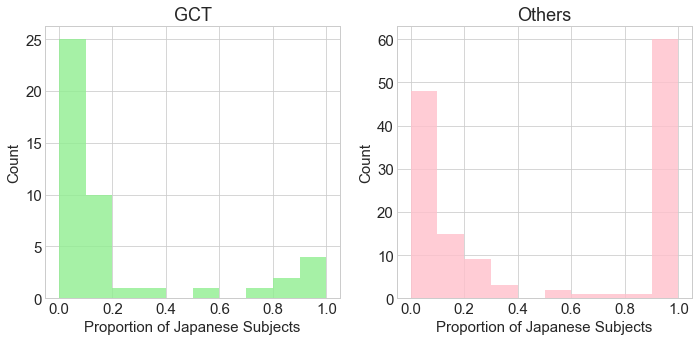

In [186]:
# check the distributions of FStudysize
plt.rcParams["font.size"] = 15

fig, ax = plt.subplots(1, 2,
                       sharex = True,
                       figsize = (10, 5))

ax[0].hist(pilot.query('GCT == 1').Pr_JStudysize,
           bins = 10,
           alpha = 0.8,
           color = 'lightgreen')
ax[1].hist(pilot.query('GCT == 0').Pr_JStudysize,
           bins = 10,
           alpha = 0.8,
           color = 'pink')
labels = ['GCT', 'Others']
for i in range(2) :
    ax[i].set_xlabel('Proportion of Japanese Subjects')
    ax[i].set_ylabel('Count')
    ax[i].set_title(titles[i])

plt.tight_layout()

plt.show()

In [187]:
# create a new column, which categorizes PR_JStudysize
def js_cate(x) :
    if x <= 0.20 :
        return 0
    else :
        return 1

pilot['Pr_JS_binom'] = pilot['Pr_JStudysize'].apply(js_cate)

In [188]:
# create a crosstab of Pr_JS_binom and PMSE
ct_js_pmse = pd.crosstab(pilot.Pr_JS_binom,
                         pilot.Event)
display(ct_js_pmse)

# create a crosstab of Pr_JS_binom and GCT
ct_js_gct = pd.crosstab(pilot.Pr_JS_binom,
                         pilot.GCT)
display(ct_js_gct)

Event,0,1
Pr_JS_binom,,
0,60,38
1,39,48


GCT,0,1
Pr_JS_binom,,
0,63,35
1,77,10


### Drag Class (Biologics)

In [189]:
# create a crosstab of Biologic and PMSE
ct_bio_pmse = pd.crosstab(pilot.Biologic,
                          pilot.Event)
display(ct_bio_pmse)

# create a crosstab of Biologic and GCT
ct_bio_gct = pd.crosstab(pilot.Biologic,
                         pilot.GCT)
display(ct_bio_gct)

Event,0,1
Biologic,,
0,75,76
1,24,10


GCT,0,1
Biologic,,
0,119,32
1,21,13


### First-in-class (FIC)

In [190]:
# create a crosstab of FIC and PMSE
ct_fic_pmse = pd.crosstab(pilot.FIC,
                          pilot.Event)
display(ct_fic_pmse)

# create a crosstab of FIC and GCT
ct_fic_gct = pd.crosstab(pilot.FIC,
                         pilot.GCT)
display(ct_fic_gct)

Event,0,1
FIC,,
0,45,49
1,54,37


GCT,0,1
FIC,,
0,65,29
1,75,16


### Therapeutic Area (ATC)

In [191]:
# create a crosstab of ATC and PMSE
ct_atc_pmse = pd.crosstab(pilot.ATC,
                          pilot.Event)
display(ct_atc_pmse)

# create a crosstab of ATC and GCT
ct_atc_gct = pd.crosstab(pilot.ATC,
                         pilot.GCT)
display(ct_atc_gct)

Event,0,1
ATC,,
J,4,12
L,25,29
others,70,45


GCT,0,1
ATC,,
J,14,2
L,43,11
others,83,32


### Approval Year

In [192]:
# create a crosstab of Approval_year and PMSE
ct_app_pmse = pd.crosstab(pilot.Approval_year,
                          pilot.Event)
display(ct_app_pmse)

# create a crosstab of Approval_year and GCT
ct_app_gct = pd.crosstab(pilot.Approval_year,
                         pilot.GCT)
display(ct_app_gct)

Event,0,1
Approval_year,,
2011,8,12
2012,18,21
2013,13,12
2014,28,26
2015,18,13
2016,14,2


GCT,0,1
Approval_year,,
2011,17,3
2012,34,5
2013,20,5
2014,40,14
2015,22,9
2016,7,9


In [193]:
# check the dataset after modifications
pilot.head()

,Days_for_approval,GCT,Lag,Studysize,JStudysize,Biologic,FIC,ATC,Event,TimetoEvent,Pr_JStudysize,Approval_year,Lag_log,Pr_JS_binom
Ingredient,,,,,,,,,,,,,,
コラゲナーゼ（クロストリジウム ヒストリチクム）,337,0,5.416438,1184,102,0,1,others,0,4.441096,0.086149,2015,0.733714,0
スクロオキシ水酸化鉄,313,0,1.835616,494,494,0,0,others,0,4.202740,1.000000,2015,0.263782,1
ルストロンボパグ,285,0,1.000000,220,220,0,1,others,0,4.202740,1.000000,2015,0.000000,1
イロプロスト,277,0,12.041096,406,49,0,1,others,0,4.202740,0.120690,2015,1.080666,0
エボロクマブ（遺伝子組み換え）,308,1,0.517808,5115,579,1,1,others,0,3.884932,0.113196,2016,-0.285831,0


## Propensity Score Matching (PSM)  
Based on EDA, the probability that the development strategy (i.e. GCT/Others) is allocated as GCT is caluculated by PSM with the following covariates :  
'Log_lag', 'JStudysize', 'Pr_JS_binom', 'Biologic', 'FIC', 'ATC'